In [ ]:
!pip install mne scikit-learn seaborn

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configuration
plt.rcParams['figure.figsize'] = (12, 8)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('ggplot')

print(f"MNE Version: {mne.__version__}")

MNE Version: 1.10.2


In [ ]:
EPOCHS_DIR = "./epochs_fif"
SUBJECT_ID = "sub-01" 
FILE_PATH = os.path.join(EPOCHS_DIR, f"{SUBJECT_ID}_epo.fif")

def load_and_balance_epochs(file_path, max_trials=None):
    """Loads epochs and balances Frequent vs Target classes."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    print(f"Loading {file_path}...")
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    
    try:
        epochs_freq = epochs['Standard'] 
        epochs_targ = epochs['Target']   
    except KeyError:
        events = epochs.events[:, 2]
        unique_events = np.unique(events)
        epochs_freq = epochs[events == unique_events[0]]
        epochs_targ = epochs[events == unique_events[1]]

    n_min = min(len(epochs_freq), len(epochs_targ))
    if max_trials:
        n_min = min(n_min, max_trials)
        
    epochs_freq = epochs_freq[:n_min]
    epochs_targ = epochs_targ[:n_min]
    
    print(f"Balanced Data: {n_min} trials per class.")
    
    epochs_balanced = mne.concatenate_epochs([epochs_freq, epochs_targ])
    labels = np.concatenate([np.zeros(n_min), np.ones(n_min)]) 
    
    return epochs_balanced, labels

epochs, labels = load_and_balance_epochs(FILE_PATH, max_trials=100)
data = epochs.get_data(copy=True) 
times = epochs.times
ch_names = epochs.ch_names

print(f"Data Shape: {data.shape} (Trials, Channels, Time)")

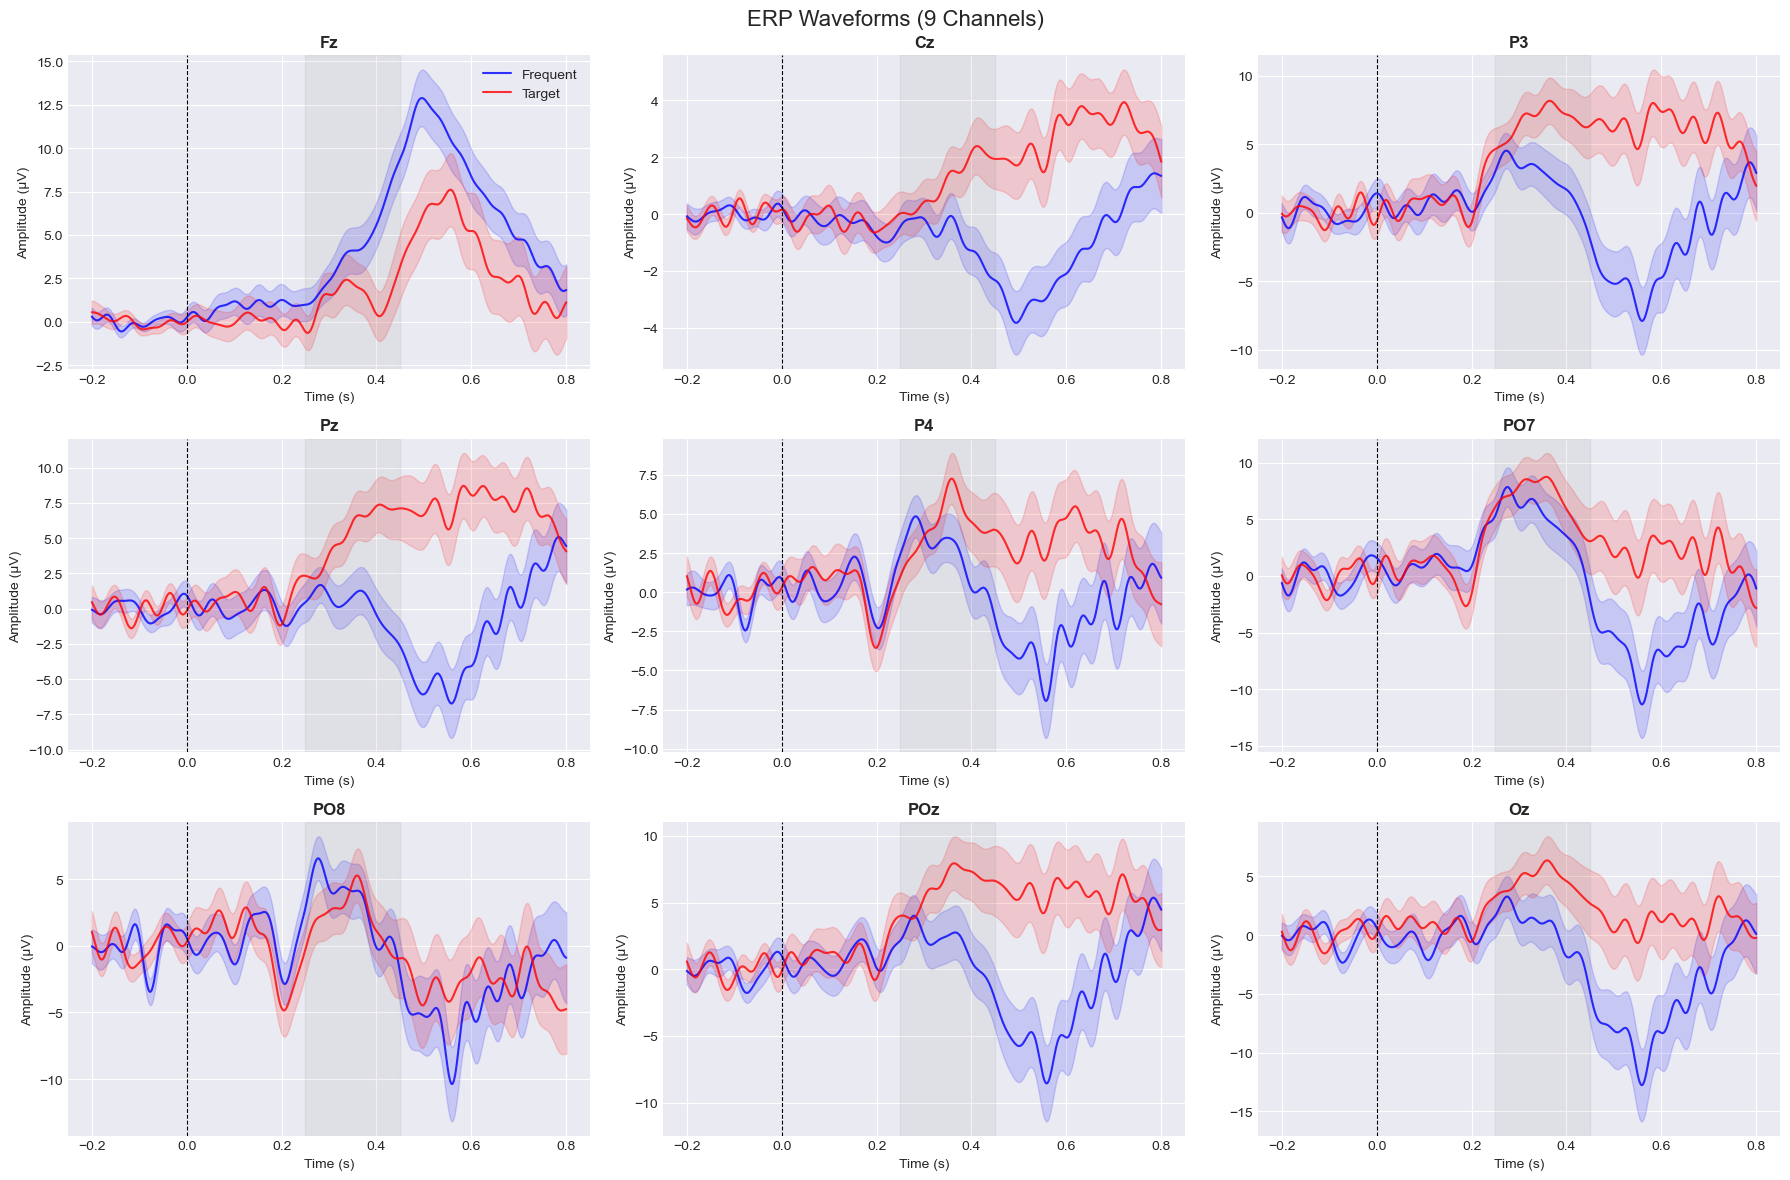

In [9]:
# Define 9 channels of interest (Midline, Parietal, Occipital)
picks = ["Fz", "Cz", "P3", "Pz", "P4", "PO7", "PO8", "POz", "Oz"]
available_picks = [ch for ch in picks if ch in ch_names]

# Fallback: Use first 9 channels if specific picks are missing
if not available_picks:
    print("Targeted channels not found. Using first 9 available channels.")
    available_picks = ch_names[:9]

# Setup 3x3 Grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Hide axis if no channel is available for this slot
    if i >= len(available_picks):
        ax.axis('off')
        continue

    ch_name = available_picks[i]
    ch_idx = ch_names.index(ch_name)
    
    # Extract data (Freq=0, Target=1) & Convert to µV
    freq_data = data[labels == 0, ch_idx, :] * 1e6
    targ_data = data[labels == 1, ch_idx, :] * 1e6
    
    # Calculate Mean and SEM
    mean_freq = freq_data.mean(axis=0)
    sem_freq = freq_data.std(axis=0) / np.sqrt(freq_data.shape[0])
    
    mean_targ = targ_data.mean(axis=0)
    sem_targ = targ_data.std(axis=0) / np.sqrt(targ_data.shape[0])
    
    # Plot Waveforms
    ax.plot(times, mean_freq, color='blue', label='Frequent', alpha=0.8)
    ax.fill_between(times, mean_freq - sem_freq, mean_freq + sem_freq, color='blue', alpha=0.15)
    
    ax.plot(times, mean_targ, color='red', label='Target', alpha=0.8)
    ax.fill_between(times, mean_targ - sem_targ, mean_targ + sem_targ, color='red', alpha=0.15)
    
    # Visual Highlights
    ax.axvspan(0.25, 0.45, color='gray', alpha=0.1) # P300 Window
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    
    # Formatting
    ax.set_title(f"{ch_name}", fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (µV)")
    
    # Legend only on the first plot to reduce clutter
    if i == 0:
        ax.legend(loc='upper right')

plt.suptitle("ERP Waveforms (9 Channels)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

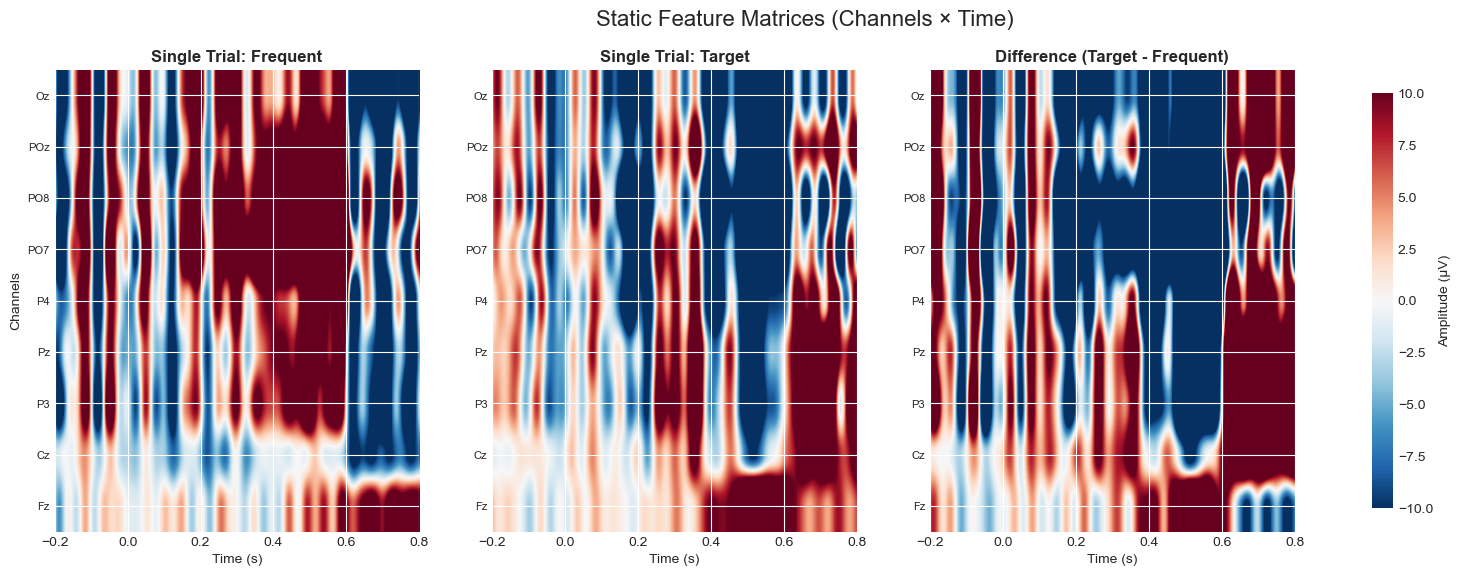

In [5]:
# Select one random trial from each class
idx_freq = np.where(labels == 0)[0][0]
idx_targ = np.where(labels == 1)[0][0]

trial_freq = data[idx_freq] * 1e6 # Convert to uV
trial_targ = data[idx_targ] * 1e6

# Calculate Difference
trial_diff = trial_targ - trial_freq

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Helper to plot heatmap
def plot_matrix(ax, data_matrix, title):
    im = ax.imshow(data_matrix, aspect='auto', cmap='RdBu_r', 
                   origin='lower', vmin=-10, vmax=10,
                   extent=[times[0], times[-1], 0, len(ch_names)])
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks(np.arange(len(ch_names)) + 0.5)
    ax.set_yticklabels(ch_names, fontsize=8)
    return im

im1 = plot_matrix(axes[0], trial_freq, "Single Trial: Frequent")
im2 = plot_matrix(axes[1], trial_targ, "Single Trial: Target")
im3 = plot_matrix(axes[2], trial_diff, "Difference (Target - Frequent)")

axes[0].set_ylabel("Channels")
fig.colorbar(im3, ax=axes.ravel().tolist(), label='Amplitude (µV)', shrink=0.9)

plt.suptitle("Static Feature Matrices (Channels × Time)", fontsize=16)
plt.show()

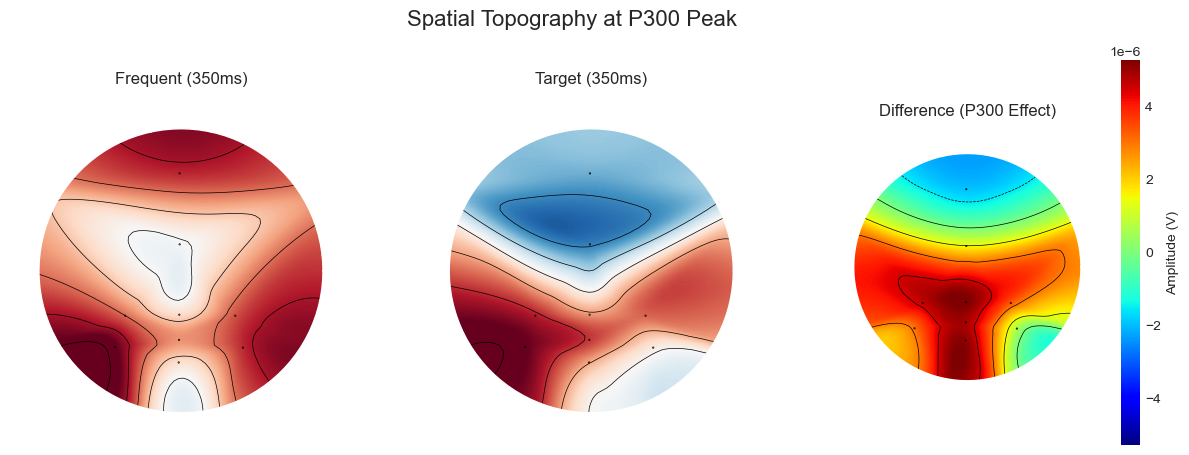

In [6]:
# Define P300 peak time (approx 350ms)
target_time = 0.350 
time_idx = np.abs(times - target_time).argmin()

# Get average topography at this time point
topo_freq = data[labels == 0, :, time_idx].mean(axis=0)
topo_targ = data[labels == 1, :, time_idx].mean(axis=0)
topo_diff = topo_targ - topo_freq

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot settings
v_lim = np.max(np.abs(topo_diff)) # Dynamic scale

# 1. Frequent
mne.viz.plot_topomap(topo_freq, epochs.info, axes=axes[0], show=False, cmap='RdBu_r')
axes[0].set_title(f"Frequent ({target_time*1000:.0f}ms)")

# 2. Target
mne.viz.plot_topomap(topo_targ, epochs.info, axes=axes[1], show=False, cmap='RdBu_r')
axes[1].set_title(f"Target ({target_time*1000:.0f}ms)")

# 3. Difference (The P300 Effect)
im, _ = mne.viz.plot_topomap(topo_diff, epochs.info, axes=axes[2], show=False, cmap='jet')
axes[2].set_title("Difference (P300 Effect)")

# Add colorbar manually for the difference plot
plt.colorbar(im, ax=axes[2], label='Amplitude (V)')

plt.suptitle("Spatial Topography at P300 Peak", fontsize=16)
plt.show()

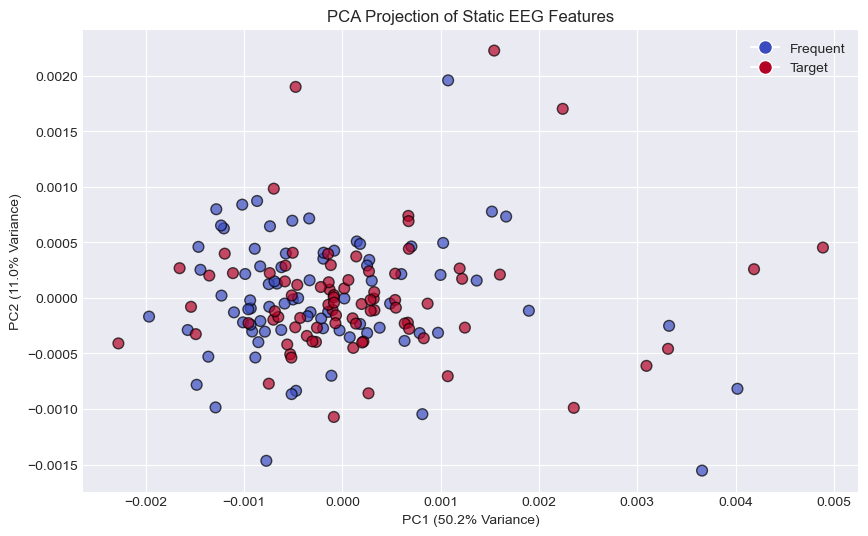

In [7]:
# 1. Flatten Data: (Trials, Channels, Time) -> (Trials, Features)
n_trials, n_ch, n_time = data.shape
X = data.reshape(n_trials, -1)
y = labels

# 2. PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 3. Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', 
                      edgecolor='k', alpha=0.7, s=60)

# Create legend handles manually for clarity
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(0.0), label='Frequent', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(1.0), label='Target', markersize=10)
]

plt.legend(handles=legend_elements)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)")
plt.title("PCA Projection of Static EEG Features")
plt.show()